<a href="https://colab.research.google.com/github/annasree/Image-Segmentation/blob/main/Image_Segmentation_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation COCO-2017 Data

In [ ]:
# import necessory modules
import os,glob,sys
import cv2
import tqdm
import warnings
import matplotlib
import numpy as np
from PIL import Image
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics, preprocessing
from keras.utils import to_categorical
from tqdm import tqdm
from pathlib import Path
import random
from typing import Any, Callable, List, Optional, Tuple
import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO
import skimage.io as io
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import io, transforms
import torchvision.transforms.functional as TF
from tqdm.auto import tqdm
from google.colab import drive
import skimage.io as io
from skimage.draw import polygon
from skimage.io import imsave
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models



In [ ]:
# import data
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip" -d "/content/drive/MyDrive/Assignment_data/"


Mounted at /content/drive
Archive:  /content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip
  inflating: /content/drive/MyDrive/Assignment_data/test-30/000000001751.jpg  
  inflating: /content/drive/MyDrive/Assignment_data/test-30/000000001380.jpg  
  inflating: /content/drive/MyDrive/Assignment_data/test-30/000000001643.jpg  
  inflating: /content/drive/MyDrive/Assignment_data/test-30/000000001583.jpg  
  inflating: /content/drive/MyDrive/Assignment_data/test-30/000000001685.jpg  
  inflating: /content/drive/MyDrive/Assignment_data/test-30/000000001482.jpg  
  inflating: /content/drive/MyDrive/Assignment_data/test-30/000000001494.jpg  
  inflating: /content/drive/MyDrive/Assignment_data/test-30/000000001551.jpg  
  inflating: /content/drive/MyDrive/Assignment_data/test-30/000000001654.jpg  
  inflating: /content/drive/MyDrive/Assignment_data/test-30/000000001594.jpg  
  inflating: /content/drive/MyDrive/Assignment_data/test-30/000000001411.jpg  
  inflating: /content/drive/MyDri

In [ ]:
# folder paths
train_img_path = "/content/drive/MyDrive/Assignment_data/train-300/data"
train_json_path = "/content/drive/MyDrive/Assignment_data/train-300/labels.json"
valid_img_path = "/content/drive/MyDrive/Assignment_data/validation-300/data"
valid_json_path = "/content/drive/MyDrive/Assignment_data/validation-300/labels.json"


In [ ]:
# load annotations
coco_train = COCO(train_json_path)
coco_valid = COCO(valid_json_path)


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


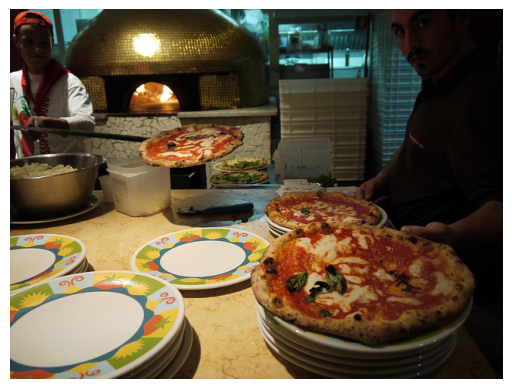

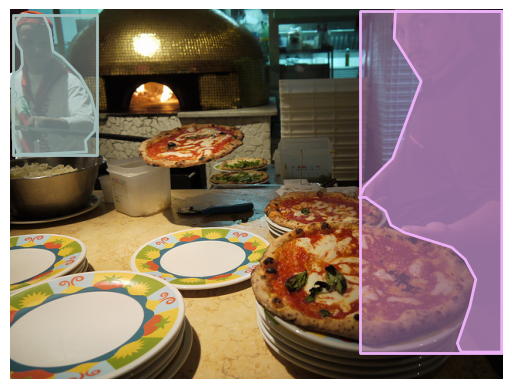

In [ ]:
# example of an image and corresponding mask from training set
dataDir = train_img_path
coco = coco_train

catIds = coco.getCatIds(catNms=['person'])
imgIds = coco.getImgIds(catIds=catIds)
img = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]

I = io.imread(f'{dataDir}/{img["file_name"]}')
plt.axis('off')
plt.imshow(I)
plt.show()

plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)


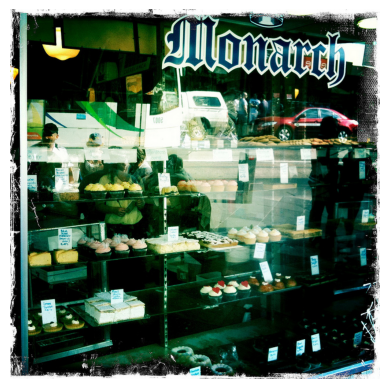

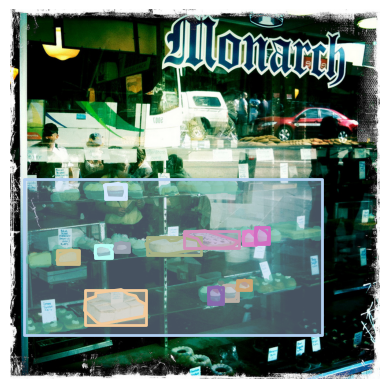

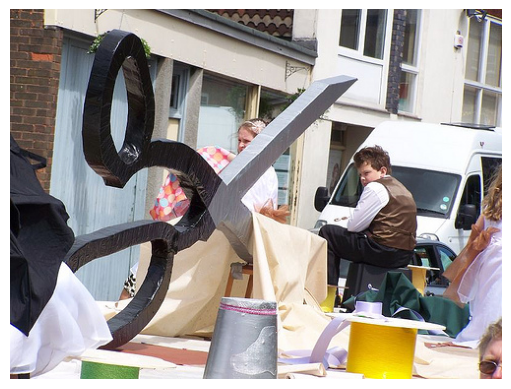

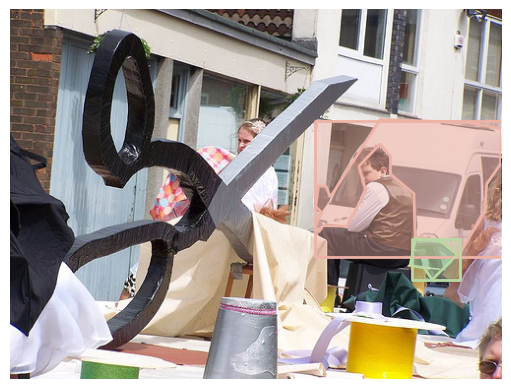

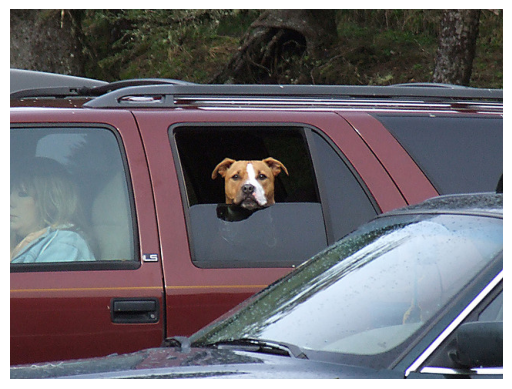

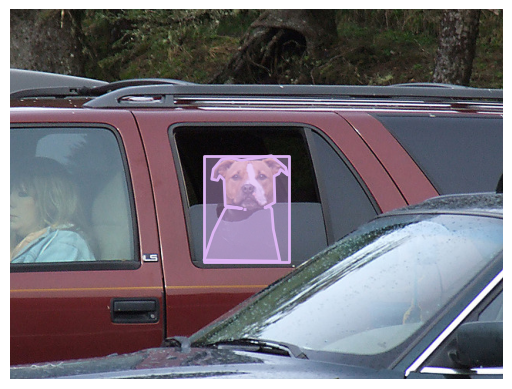

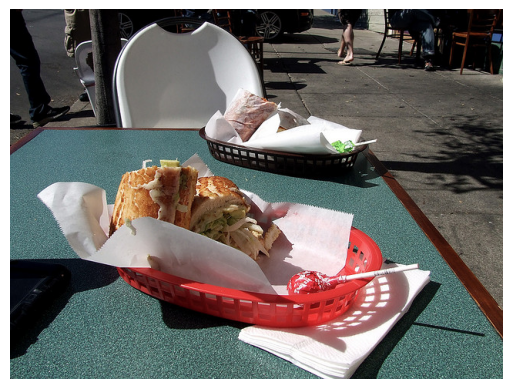

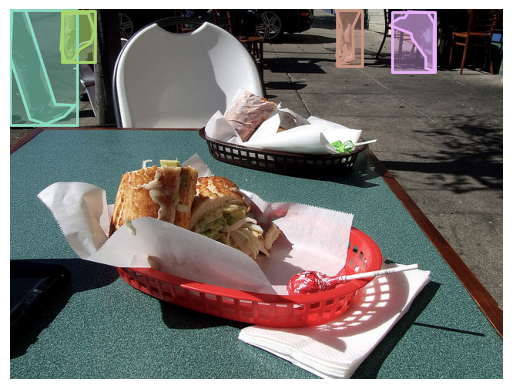

In [ ]:
# training set
dataDir = train_img_path
coco = coco_train

categories_of_interest = ['person', 'car', 'dog', 'cake']
catIds = coco.getCatIds(catNms=categories_of_interest)


for catId in catIds:
    imgIds = coco.getImgIds(catIds=[catId])
    img = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]

    # Load and display the image
    I = io.imread(f'{dataDir}/{img["file_name"]}')
    plt.axis('off')
    plt.imshow(I)
    plt.show()

    annIds = coco.getAnnIds(imgIds=img['id'], catIds=[catId], iscrowd=None)
    anns = coco.loadAnns(annIds)

    # Display annotations with bounding boxes
    plt.imshow(I)
    coco.showAnns(anns, draw_bbox=True)
    plt.axis('off')
    plt.show()


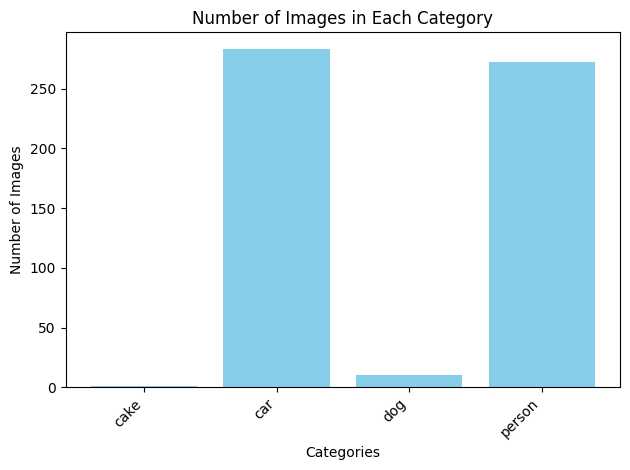

In [ ]:
# Define categories of interest
categories_of_interest = ['person', 'car', 'dog', 'cake']

catIds = coco.getCatIds(catNms=categories_of_interest)
category_counts = {}

# Iterate over each category
for catId in catIds:
    imgIds = coco.getImgIds(catIds=[catId])
    category_name = coco.loadCats(catId)[0]['name']
    category_counts[category_name] = len(imgIds)

# Plot the number of images in each category
plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Define the root directory
root_dir = '/content/drive/MyDrive/Assignment_data'

# Define the subdirectories
subdirs = ['train/images', 'train/masks', 'validation/images', 'validation/masks', 'test/masks']

# Create directories if they don't exist
for subdir in subdirs:
    directory = os.path.join(root_dir, subdir)
    if not os.path.exists(directory):
        os.makedirs(directory)


In [ ]:
# Function to create a mask from polygon annotations
def create_mask_from_polygons(height, width, polygons):
    mask = np.zeros((height, width), dtype=np.uint8)
    for seg in polygons:
        poly = np.array(seg).reshape((int(len(seg)/2), 2))
        rr, cc = polygon(poly[:, 1], poly[:, 0], mask.shape)
        mask[rr, cc] = 1
    return mask

coco = COCO("/content/drive/MyDrive/Assignment_data/train-300/labels.json")

categories_of_interest = ['person', 'car', 'dog', 'cake']
catIds = coco.getCatIds(catNms=categories_of_interest)

# Directory to save masks
output_mask_dir = "/content/drive/MyDrive/Assignment_data/train/masks"
os.makedirs(output_mask_dir, exist_ok=True)

# Loop through each image in the dataset
for img_id in coco.imgs:
    img_info = coco.loadImgs(img_id)[0]
    img_height, img_width = img_info['height'], img_info['width']
    annIds = coco.getAnnIds(imgIds=img_id, catIds=catIds)
    annotations = coco.loadAnns(annIds)
    mask = np.zeros((img_height, img_width), dtype=np.uint8)

    # Iterate through annotations and create masks
    for ann in annotations:
        if 'segmentation' in ann:
            if isinstance(ann['segmentation'], dict):
                mask += coco.annToMask(ann)
            else:
                mask += create_mask_from_polygons(img_height, img_width, ann['segmentation'])

    mask = np.where(mask > 0, 255, 0).astype(np.uint8)

    # Save the mask
    mask_filename = f"{img_info['file_name'][:-4]}_mask.png"
    imsave(os.path.join(output_mask_dir, mask_filename), mask)

    print(f"Mask generated and saved for image {img_info['file_name']}")

print("Mask generation completed.")


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Mask generated and saved for image 000000000149.jpg
Mask generated and saved for image 000000000260.jpg
Mask generated and saved for image 000000000328.jpg
Mask generated and saved for image 000000000419.jpg
Mask generated and saved for image 000000000722.jpg
Mask generated and saved for image 000000000730.jpg
Mask generated and saved for image 000000000731.jpg
Mask generated and saved for image 000000000810.jpg
Mask generated and saved for image 000000000821.jpg
Mask generated and saved for image 000000000839.jpg
Mask generated and saved for image 000000000923.jpg
Mask generated and saved for image 000000001006.jpg
Mask generated and saved for image 000000001053.jpg
Mask generated and saved for image 000000001144.jpg
Mask generated and saved for image 000000001311.jpg
Mask generated and saved for image 000000001315.jpg
Mask generated and saved for image 000000001523.jpg


<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000001311_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000001586.jpg
Mask generated and saved for image 000000001720.jpg
Mask generated and saved for image 000000001799.jpg
Mask generated and saved for image 000000001915.jpg
Mask generated and saved for image 000000001924.jpg
Mask generated and saved for image 000000001955.jpg
Mask generated and saved for image 000000002014.jpg
Mask generated and saved for image 000000002089.jpg
Mask generated and saved for image 000000002142.jpg
Mask generated and saved for image 000000002154.jpg
Mask generated and saved for image 000000002281.jpg
Mask generated and saved for image 000000002459.jpg
Mask generated and saved for image 000000002644.jpg
Mask generated and saved for image 000000002687.jpg
Mask generated and saved for image 000000002754.jpg
Mask generated and saved for image 000000002774.jpg
Mask generated and saved for image 000000002782.jpg
Mask generated and saved for image 000000002860.jpg
Mask generated and saved for image 000000002890.jpg
Mask generat

<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000004551_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000004665.jpg
Mask generated and saved for image 000000004700.jpg
Mask generated and saved for image 000000004736.jpg
Mask generated and saved for image 000000004968.jpg
Mask generated and saved for image 000000004988.jpg
Mask generated and saved for image 000000005018.jpg
Mask generated and saved for image 000000005073.jpg
Mask generated and saved for image 000000005105.jpg
Mask generated and saved for image 000000005107.jpg
Mask generated and saved for image 000000005156.jpg
Mask generated and saved for image 000000005205.jpg
Mask generated and saved for image 000000005256.jpg
Mask generated and saved for image 000000005282.jpg
Mask generated and saved for image 000000005294.jpg


<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000005282_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000005601_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000005684_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000005769_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000005325.jpg
Mask generated and saved for image 000000005336.jpg
Mask generated and saved for image 000000005394.jpg
Mask generated and saved for image 000000005601.jpg
Mask generated and saved for image 000000005620.jpg
Mask generated and saved for image 000000005684.jpg
Mask generated and saved for image 000000005756.jpg
Mask generated and saved for image 000000005769.jpg
Mask generated and saved for image 000000006004.jpg
Mask generated and saved for image 000000006233.jpg
Mask generated and saved for image 000000006414.jpg
Mask generated and saved for image 000000006517.jpg
Mask generated and saved for image 000000006522.jpg

<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000006004_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000006414_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)



Mask generated and saved for image 000000006531.jpg
Mask generated and saved for image 000000006562.jpg
Mask generated and saved for image 000000006602.jpg
Mask generated and saved for image 000000006709.jpg
Mask generated and saved for image 000000006789.jpg
Mask generated and saved for image 000000006811.jpg
Mask generated and saved for image 000000006935.jpg
Mask generated and saved for image 000000007104.jpg
Mask generated and saved for image 000000007124.jpg
Mask generated and saved for image 000000007178.jpg
Mask generated and saved for image 000000007201.jpg
Mask generated and saved for image 000000007228.jpg
Mask generated and saved for image 000000007297.jpg
Mask generated and saved for image 000000007298.jpg


<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000007178_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000007726_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000007325.jpg
Mask generated and saved for image 000000007650.jpg
Mask generated and saved for image 000000007685.jpg
Mask generated and saved for image 000000007726.jpg
Mask generated and saved for image 000000007819.jpg
Mask generated and saved for image 000000007938.jpg
Mask generated and saved for image 000000008019.jpg
Mask generated and saved for image 000000008025.jpg
Mask generated and saved for image 000000008086.jpg
Mask generated and saved for image 000000008187.jpg


<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000008187_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000008309.jpg
Mask generated and saved for image 000000008339.jpg
Mask generated and saved for image 000000008593.jpg
Mask generated and saved for image 000000008834.jpg
Mask generated and saved for image 000000008965.jpg
Mask generated and saved for image 000000009112.jpg
Mask generated and saved for image 000000009133.jpg
Mask generated and saved for image 000000009274.jpg
Mask generated and saved for image 000000009286.jpg
Mask generated and saved for image 000000009317.jpg
Mask generated and saved for image 000000009379.jpg


<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000009379_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000009488.jpg
Mask generated and saved for image 000000009542.jpg
Mask generated and saved for image 000000009572.jpg
Mask generated and saved for image 000000009615.jpg
Mask generated and saved for image 000000009647.jpg
Mask generated and saved for image 000000009648.jpg
Mask generated and saved for image 000000009801.jpg
Mask generated and saved for image 000000009885.jpg
Mask generated and saved for image 000000009941.jpg
Mask generated and saved for image 000000009999.jpg
Mask generated and saved for image 000000010014.jpg
Mask generated and saved for image 000000010056.jpg
Mask generated and saved for image 000000010318.jpg
Mask generated and saved for image 000000010393.jpg
Mask generated and saved for image 000000010434.jpg
Mask generated and saved for image 000000010545.jpg
Mask generated and saved for image 000000010613.jpg
Mask generated and saved for image 000000010615.jpg
Mask generated and saved for image 000000010639.jpg
Mask generat

<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000011569_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000011569.jpg
Mask generated and saved for image 000000011579.jpg
Mask generated and saved for image 000000011619.jpg
Mask generated and saved for image 000000011624.jpg
Mask generated and saved for image 000000011690.jpg
Mask generated and saved for image 000000011788.jpg
Mask generated and saved for image 000000011838.jpg
Mask generated and saved for image 000000011968.jpg
Mask generated and saved for image 000000012020.jpg
Mask generated and saved for image 000000012093.jpg
Mask generated and saved for image 000000012108.jpg
Mask generated and saved for image 000000012109.jpg
Mask generated and saved for image 000000012131.jpg


<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000012093_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000012145.jpg
Mask generated and saved for image 000000012230.jpg
Mask generated and saved for image 000000012238.jpg
Mask generated and saved for image 000000012283.jpg
Mask generated and saved for image 000000012370.jpg
Mask generated and saved for image 000000012418.jpg
Mask generated and saved for image 000000012544.jpg
Mask generated and saved for image 000000012666.jpg
Mask generated and saved for image 000000012726.jpg
Mask generated and saved for image 000000012818.jpg
Mask generated and saved for image 000000012861.jpg
Mask generated and saved for image 000000012891.jpg
Mask generated and saved for image 000000012946.jpg
Mask generated and saved for image 000000012993.jpg
Mask generated and saved for image 000000013082.jpg


<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000012891_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000012993_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000013143.jpg
Mask generated and saved for image 000000013172.jpg
Mask generated and saved for image 000000013198.jpg
Mask generated and saved for image 000000013230.jpg
Mask generated and saved for image 000000013258.jpg
Mask generated and saved for image 000000013274.jpg
Mask generated and saved for image 000000013290.jpg
Mask generated and saved for image 000000013296.jpg
Mask generated and saved for image 000000013325.jpg
Mask generated and saved for image 000000013379.jpg
Mask generated and saved for image 000000013489.jpg


<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000013325_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000013576.jpg
Mask generated and saved for image 000000013720.jpg
Mask generated and saved for image 000000013815.jpg
Mask generated and saved for image 000000013867.jpg
Mask generated and saved for image 000000013909.jpg
Mask generated and saved for image 000000013944.jpg
Mask generated and saved for image 000000014128.jpg


<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000013944_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000014152.jpg
Mask generated and saved for image 000000014244.jpg
Mask generated and saved for image 000000014257.jpg
Mask generated and saved for image 000000014278.jpg
Mask generated and saved for image 000000014312.jpg
Mask generated and saved for image 000000014375.jpg
Mask generated and saved for image 000000014388.jpg
Mask generated and saved for image 000000014392.jpg
Mask generated and saved for image 000000014698.jpg
Mask generated and saved for image 000000014757.jpg
Mask generated and saved for image 000000014768.jpg
Mask generated and saved for image 000000014876.jpg
Mask generated and saved for image 000000014886.jpg
Mask generated and saved for image 000000014985.jpg
Mask generated and saved for image 000000014986.jpg
Mask generated and saved for image 000000015069.jpg
Mask generated and saved for image 000000015110.jpg
Mask generated and saved for image 000000015153.jpg
Mask generated and saved for image 000000015157.jpg
Mask generat

<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000015276_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000015289_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000015652_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000015902.jpg
Mask generated and saved for image 000000015919.jpg
Mask generated and saved for image 000000016039.jpg
Mask generated and saved for image 000000016060.jpg
Mask generated and saved for image 000000016076.jpg
Mask generated and saved for image 000000016254.jpg
Mask generated and saved for image 000000016285.jpg
Mask generated and saved for image 000000016346.jpg
Mask generated and saved for image 000000016356.jpg
Mask generated and saved for image 000000016403.jpg
Mask generated and saved for image 000000016412.jpg
Mask generated and saved for image 000000016513.jpg
Mask generated and saved for image 000000016578.jpg
Mask generated and saved for image 000000016599.jpg


<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000016513_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000016616.jpg
Mask generated and saved for image 000000016665.jpg
Mask generated and saved for image 000000016672.jpg
Mask generated and saved for image 000000016737.jpg
Mask generated and saved for image 000000016961.jpg
Mask generated and saved for image 000000016977.jpg
Mask generated and saved for image 000000534763.jpg
Mask generated and saved for image 000000000064.jpg
Mask generated and saved for image 000000000071.jpg
Mask generated and saved for image 000000000094.jpg
Mask generated and saved for image 000000000110.jpg
Mask generated and saved for image 000000000247.jpg
Mask generated and saved for image 000000000307.jpg
Mask generated and saved for image 000000000359.jpg


<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000000071_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000000094_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000000471_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000000397.jpg
Mask generated and saved for image 000000000471.jpg
Mask generated and saved for image 000000000532.jpg
Mask generated and saved for image 000000000540.jpg
Mask generated and saved for image 000000000641.jpg
Mask generated and saved for image 000000000650.jpg
Mask generated and saved for image 000000000656.jpg
Mask generated and saved for image 000000000775.jpg
Mask generated and saved for image 000000000985.jpg
Mask generated and saved for image 000000001171.jpg
Mask generated and saved for image 000000001307.jpg


<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000000540_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000000641_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000000775_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000001171_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000001366_mask.png is a low contrast image
  imsave(os.path.join(output_ma

Mask generated and saved for image 000000001366.jpg
Mask generated and saved for image 000000001374.jpg
Mask generated and saved for image 000000001408.jpg
Mask generated and saved for image 000000001518.jpg
Mask generated and saved for image 000000001536.jpg
Mask generated and saved for image 000000001709.jpg
Mask generated and saved for image 000000001762.jpg
Mask generated and saved for image 000000001875.jpg
Mask generated and saved for image 000000002209.jpg
Mask generated and saved for image 000000002309.jpg


<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000001762_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000002209_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000002309_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000002640_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000002822_mask.png is a low contrast image
  imsave(os.path.join(output_ma

Mask generated and saved for image 000000002529.jpg
Mask generated and saved for image 000000002639.jpg
Mask generated and saved for image 000000002640.jpg
Mask generated and saved for image 000000002742.jpg
Mask generated and saved for image 000000002822.jpg
Mask generated and saved for image 000000002985.jpg
Mask generated and saved for image 000000003035.jpg
Mask generated and saved for image 000000003134.jpg
Mask generated and saved for image 000000003148.jpg
Mask generated and saved for image 000000003668.jpg
Mask generated and saved for image 000000003711.jpg
Mask generated and saved for image 000000003793.jpg
Mask generated and saved for image 000000003804.jpg
Mask generated and saved for image 000000003849.jpg
Mask generated and saved for image 000000003911.jpg
Mask generated and saved for image 000000003935.jpg


<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000003793_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-9-01d605666fce>:39: UserWarning: /content/drive/MyDrive/Assignment_data/train/masks/000000003849_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000003983.jpg
Mask generation completed.


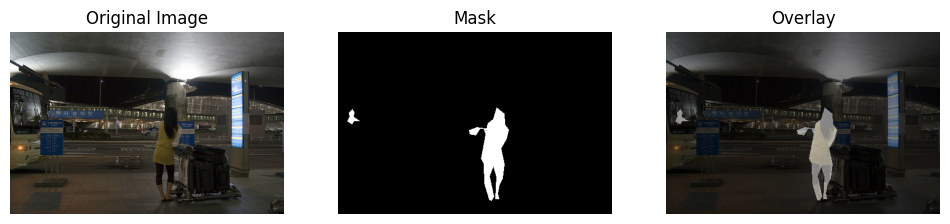

In [ ]:
# Define the paths to the image and mask
image_path = '/content/drive/MyDrive/Assignment_data/train-300/data/000000000260.jpg'
mask_path = '/content/drive/MyDrive/Assignment_data/train/masks/000000000260_mask.png'

# Load the image
image = Image.open(image_path)

# Load the mask
mask = Image.open(mask_path)

# Overlay the mask on the image
overlay = Image.blend(image.convert("RGBA"), mask.convert("RGBA"), alpha=0.5)

# Plot the original image, mask, and overlay
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title('Overlay')
plt.axis('off')

plt.show()


In [ ]:
# Function to create a mask from polygon annotations
def create_mask_from_polygons(height, width, polygons):
    mask = np.zeros((height, width), dtype=np.uint8)
    for seg in polygons:
        poly = np.array(seg).reshape((int(len(seg)/2), 2))
        rr, cc = polygon(poly[:, 1], poly[:, 0], mask.shape)
        mask[rr, cc] = 1
    return mask

coco = COCO("/content/drive/MyDrive/Assignment_data/validation-300/labels.json")

categories_of_interest = ['person', 'car', 'dog', 'cake']
catIds = coco.getCatIds(catNms=categories_of_interest)

output_mask_dir = "/content/drive/MyDrive/Assignment_data/validation/masks"
os.makedirs(output_mask_dir, exist_ok=True)

# Loop through each image in the dataset
for img_id in coco.imgs:
    img_info = coco.loadImgs(img_id)[0]
    img_height, img_width = img_info['height'], img_info['width']
    annIds = coco.getAnnIds(imgIds=img_id, catIds=catIds)
    annotations = coco.loadAnns(annIds)
    mask = np.zeros((img_height, img_width), dtype=np.uint8)

    # Iterate through annotations and create masks
    for ann in annotations:
        if 'segmentation' in ann:
            if isinstance(ann['segmentation'], dict):
                mask += coco.annToMask(ann)
            else:
                mask += create_mask_from_polygons(img_height, img_width, ann['segmentation'])

    mask = np.where(mask > 0, 255, 0).astype(np.uint8)

    # Save the mask
    mask_filename = f"{img_info['file_name'][:-4]}_mask.png"
    imsave(os.path.join(output_mask_dir, mask_filename), mask)

    print(f"Mask generated and saved for image {img_info['file_name']}")

print("Mask generation completed.")


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Mask generated and saved for image 000000000724.jpg
Mask generated and saved for image 000000001532.jpg
Mask generated and saved for image 000000001584.jpg
Mask generated and saved for image 000000002006.jpg
Mask generated and saved for image 000000005037.jpg
Mask generated and saved for image 000000006040.jpg
Mask generated and saved for image 000000006723.jpg
Mask generated and saved for image 000000007088.jpg
Mask generated and saved for image 000000008762.jpg


<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000000724_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000006040_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000006723_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000008762_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000009891.jpg
Mask generated and saved for image 000000010363.jpg
Mask generated and saved for image 000000011197.jpg
Mask generated and saved for image 000000012576.jpg
Mask generated and saved for image 000000014380.jpg
Mask generated and saved for image 000000015338.jpg
Mask generated and saved for image 000000017029.jpg


<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000014380_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000015338_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000017178.jpg
Mask generated and saved for image 000000017207.jpg
Mask generated and saved for image 000000017627.jpg
Mask generated and saved for image 000000018150.jpg
Mask generated and saved for image 000000018837.jpg
Mask generated and saved for image 000000019042.jpg


<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000019042_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000022755_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000019402.jpg
Mask generated and saved for image 000000021839.jpg
Mask generated and saved for image 000000022755.jpg
Mask generated and saved for image 000000023272.jpg
Mask generated and saved for image 000000025393.jpg
Mask generated and saved for image 000000025603.jpg
Mask generated and saved for image 000000026204.jpg
Mask generated and saved for image 000000026926.jpg
Mask generated and saved for image 000000027696.jpg
Mask generated and saved for image 000000027768.jpg
Mask generated and saved for image 000000030828.jpg
Mask generated and saved for image 000000031118.jpg
Mask generated and saved for image 000000032038.jpg
Mask generated and saved for image 000000032334.jpg
Mask generated and saved for image 000000032941.jpg
Mask generated and saved for image 000000033109.jpg


<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000032941_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000033109_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000038048_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000041633_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000042070_mask.png is a low contrast image
 

Mask generated and saved for image 000000033221.jpg
Mask generated and saved for image 000000033759.jpg
Mask generated and saved for image 000000033854.jpg
Mask generated and saved for image 000000038048.jpg
Mask generated and saved for image 000000039484.jpg
Mask generated and saved for image 000000040083.jpg
Mask generated and saved for image 000000041633.jpg
Mask generated and saved for image 000000042070.jpg
Mask generated and saved for image 000000043737.jpg
Mask generated and saved for image 000000044590.jpg
Mask generated and saved for image 000000045596.jpg
Mask generated and saved for image 000000046872.jpg
Mask generated and saved for image 000000047112.jpg
Mask generated and saved for image 000000047828.jpg


<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000045596_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000047112_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000053994_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000050679.jpg
Mask generated and saved for image 000000052007.jpg
Mask generated and saved for image 000000052412.jpg
Mask generated and saved for image 000000053994.jpg
Mask generated and saved for image 000000054593.jpg
Mask generated and saved for image 000000054967.jpg
Mask generated and saved for image 000000055150.jpg
Mask generated and saved for image 000000055167.jpg


<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000055167_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000057149.jpg
Mask generated and saved for image 000000057597.jpg
Mask generated and saved for image 000000057672.jpg
Mask generated and saved for image 000000058350.jpg
Mask generated and saved for image 000000058539.jpg


<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000059386_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000059386.jpg
Mask generated and saved for image 000000061108.jpg
Mask generated and saved for image 000000062808.jpg
Mask generated and saved for image 000000064523.jpg
Mask generated and saved for image 000000065350.jpg
Mask generated and saved for image 000000065485.jpg
Mask generated and saved for image 000000067213.jpg
Mask generated and saved for image 000000067616.jpg
Mask generated and saved for image 000000068093.jpg
Mask generated and saved for image 000000069356.jpg
Mask generated and saved for image 000000074058.jpg
Mask generated and saved for image 000000074256.jpg
Mask generated and saved for image 000000074733.jpg
Mask generated and saved for image 000000076416.jpg
Mask generated and saved for image 000000076417.jpg


<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000076416_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000079034_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000081394_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000078823.jpg
Mask generated and saved for image 000000079034.jpg
Mask generated and saved for image 000000080932.jpg
Mask generated and saved for image 000000081394.jpg
Mask generated and saved for image 000000082821.jpg
Mask generated and saved for image 000000084170.jpg
Mask generated and saved for image 000000084492.jpg
Mask generated and saved for image 000000084752.jpg


<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000082821_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000084752_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000086483_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000085157.jpg
Mask generated and saved for image 000000085376.jpg
Mask generated and saved for image 000000086220.jpg
Mask generated and saved for image 000000086483.jpg
Mask generated and saved for image 000000087144.jpg
Mask generated and saved for image 000000088462.jpg
Mask generated and saved for image 000000089556.jpg
Mask generated and saved for image 000000091406.jpg
Mask generated and saved for image 000000091500.jpg
Mask generated and saved for image 000000093154.jpg
Mask generated and saved for image 000000094751.jpg
Mask generated and saved for image 000000097679.jpg
Mask generated and saved for image 000000098392.jpg
Mask generated and saved for image 000000099039.jpg


<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000100274_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000100274.jpg
Mask generated and saved for image 000000100283.jpg
Mask generated and saved for image 000000100624.jpg
Mask generated and saved for image 000000102411.jpg
Mask generated and saved for image 000000102805.jpg
Mask generated and saved for image 000000105455.jpg
Mask generated and saved for image 000000105912.jpg
Mask generated and saved for image 000000105923.jpg
Mask generated and saved for image 000000107087.jpg
Mask generated and saved for image 000000107554.jpg
Mask generated and saved for image 000000108253.jpg
Mask generated and saved for image 000000109441.jpg
Mask generated and saved for image 000000110784.jpg
Mask generated and saved for image 000000111036.jpg


<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000105455_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000107554_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000109441_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000110784_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000111086.jpg
Mask generated and saved for image 000000113235.jpg
Mask generated and saved for image 000000113720.jpg
Mask generated and saved for image 000000114770.jpg
Mask generated and saved for image 000000114884.jpg
Mask generated and saved for image 000000115946.jpg
Mask generated and saved for image 000000116208.jpg
Mask generated and saved for image 000000119911.jpg
Mask generated and saved for image 000000121242.jpg
Mask generated and saved for image 000000121506.jpg
Mask generated and saved for image 000000122166.jpg
Mask generated and saved for image 000000122606.jpg


<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000121506_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000122606_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000124277_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000122962.jpg
Mask generated and saved for image 000000124277.jpg
Mask generated and saved for image 000000124798.jpg
Mask generated and saved for image 000000125572.jpg
Mask generated and saved for image 000000125778.jpg
Mask generated and saved for image 000000126592.jpg
Mask generated and saved for image 000000127092.jpg
Mask generated and saved for image 000000127263.jpg
Mask generated and saved for image 000000127394.jpg
Mask generated and saved for image 000000128372.jpg
Mask generated and saved for image 000000130386.jpg
Mask generated and saved for image 000000130699.jpg
Mask generated and saved for image 000000132544.jpg
Mask generated and saved for image 000000133819.jpg
Mask generated and saved for image 000000134886.jpg
Mask generated and saved for image 000000135410.jpg
Mask generated and saved for image 000000135604.jpg
Mask generated and saved for image 000000136715.jpg
Mask generated and saved for image 000000137727.jpg
Mask generat

<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000144706_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000146498_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000146457.jpg
Mask generated and saved for image 000000146498.jpg
Mask generated and saved for image 000000146667.jpg
Mask generated and saved for image 000000146831.jpg
Mask generated and saved for image 000000147223.jpg
Mask generated and saved for image 000000147338.jpg
Mask generated and saved for image 000000147725.jpg
Mask generated and saved for image 000000147740.jpg
Mask generated and saved for image 000000148508.jpg
Mask generated and saved for image 000000151962.jpg
Mask generated and saved for image 000000152771.jpg
Mask generated and saved for image 000000153011.jpg
Mask generated and saved for image 000000155341.jpg


<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000152771_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000155451_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000155451.jpg
Mask generated and saved for image 000000156071.jpg
Mask generated and saved for image 000000156076.jpg
Mask generated and saved for image 000000157365.jpg
Mask generated and saved for image 000000157756.jpg
Mask generated and saved for image 000000157928.jpg
Mask generated and saved for image 000000158548.jpg
Mask generated and saved for image 000000158744.jpg
Mask generated and saved for image 000000160012.jpg
Mask generated and saved for image 000000160728.jpg
Mask generated and saved for image 000000161128.jpg
Mask generated and saved for image 000000161925.jpg
Mask generated and saved for image 000000162858.jpg
Mask generated and saved for image 000000163057.jpg
Mask generated and saved for image 000000165039.jpg
Mask generated and saved for image 000000165681.jpg
Mask generated and saved for image 000000166391.jpg
Mask generated and saved for image 000000166664.jpg
Mask generated and saved for image 000000167122.jpg
Mask generat

<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000170545_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000172330.jpg
Mask generated and saved for image 000000172571.jpg
Mask generated and saved for image 000000172648.jpg
Mask generated and saved for image 000000174123.jpg
Mask generated and saved for image 000000174482.jpg
Mask generated and saved for image 000000175438.jpg


<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000176037_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000176037.jpg
Mask generated and saved for image 000000176606.jpg
Mask generated and saved for image 000000177213.jpg
Mask generated and saved for image 000000177489.jpg
Mask generated and saved for image 000000177861.jpg
Mask generated and saved for image 000000177893.jpg
Mask generated and saved for image 000000177934.jpg
Mask generated and saved for image 000000179141.jpg
Mask generated and saved for image 000000179265.jpg


<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000177893_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000179265_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000180101.jpg
Mask generated and saved for image 000000180878.jpg
Mask generated and saved for image 000000181542.jpg
Mask generated and saved for image 000000181816.jpg
Mask generated and saved for image 000000183246.jpg
Mask generated and saved for image 000000183709.jpg
Mask generated and saved for image 000000184324.jpg
Mask generated and saved for image 000000184611.jpg
Mask generated and saved for image 000000187144.jpg
Mask generated and saved for image 000000188296.jpg
Mask generated and saved for image 000000189475.jpg
Mask generated and saved for image 000000189752.jpg
Mask generated and saved for image 000000191013.jpg
Mask generated and saved for image 000000192670.jpg
Mask generated and saved for image 000000192716.jpg
Mask generated and saved for image 000000193717.jpg
Mask generated and saved for image 000000194716.jpg
Mask generated and saved for image 000000196141.jpg
Mask generated and saved for image 000000196759.jpg
Mask generat

<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000196759_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000200839_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000201934_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000201426.jpg
Mask generated and saved for image 000000201934.jpg
Mask generated and saved for image 000000202339.jpg
Mask generated and saved for image 000000203294.jpg
Mask generated and saved for image 000000204871.jpg
Mask generated and saved for image 000000206487.jpg
Mask generated and saved for image 000000208363.jpg
Mask generated and saved for image 000000208423.jpg
Mask generated and saved for image 000000209222.jpg
Mask generated and saved for image 000000209530.jpg
Mask generated and saved for image 000000210273.jpg
Mask generated and saved for image 000000210394.jpg
Mask generated and saved for image 000000211674.jpg
Mask generated and saved for image 000000212573.jpg
Mask generated and saved for image 000000213255.jpg
Mask generated and saved for image 000000213593.jpg
Mask generated and saved for image 000000213605.jpg
Mask generated and saved for image 000000214200.jpg
Mask generated and saved for image 000000215723.jpg
Mask generat

<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000221754_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000224337.jpg
Mask generated and saved for image 000000224724.jpg
Mask generated and saved for image 000000225532.jpg
Mask generated and saved for image 000000226154.jpg
Mask generated and saved for image 000000226417.jpg
Mask generated and saved for image 000000226802.jpg
Mask generated and saved for image 000000227511.jpg
Mask generated and saved for image 000000227898.jpg
Mask generated and saved for image 000000228436.jpg
Mask generated and saved for image 000000228942.jpg
Mask generated and saved for image 000000230008.jpg
Mask generated and saved for image 000000230450.jpg


<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000230450_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000232538_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000236845_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)
<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000240940_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000230983.jpg
Mask generated and saved for image 000000231508.jpg
Mask generated and saved for image 000000232538.jpg
Mask generated and saved for image 000000233727.jpg
Mask generated and saved for image 000000233771.jpg
Mask generated and saved for image 000000236845.jpg
Mask generated and saved for image 000000240250.jpg
Mask generated and saved for image 000000240940.jpg
Mask generated and saved for image 000000242411.jpg
Mask generated and saved for image 000000243867.jpg
Mask generated and saved for image 000000244379.jpg
Mask generated and saved for image 000000245320.jpg
Mask generated and saved for image 000000246436.jpg
Mask generated and saved for image 000000248400.jpg
Mask generated and saved for image 000000254814.jpg
Mask generated and saved for image 000000255749.jpg


<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000244379_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000255917.jpg
Mask generated and saved for image 000000258793.jpg
Mask generated and saved for image 000000258883.jpg
Mask generated and saved for image 000000259571.jpg
Mask generated and saved for image 000000259690.jpg
Mask generated and saved for image 000000260266.jpg
Mask generated and saved for image 000000260470.jpg


<ipython-input-11-d8832fde4abf>:38: UserWarning: /content/drive/MyDrive/Assignment_data/validation/masks/000000258793_mask.png is a low contrast image
  imsave(os.path.join(output_mask_dir, mask_filename), mask)


Mask generated and saved for image 000000260925.jpg
Mask generated and saved for image 000000261982.jpg
Mask generated and saved for image 000000263463.jpg
Mask generated and saved for image 000000263594.jpg
Mask generated and saved for image 000000265777.jpg
Mask generated and saved for image 000000266981.jpg
Mask generated and saved for image 000000269632.jpg
Mask generation completed.


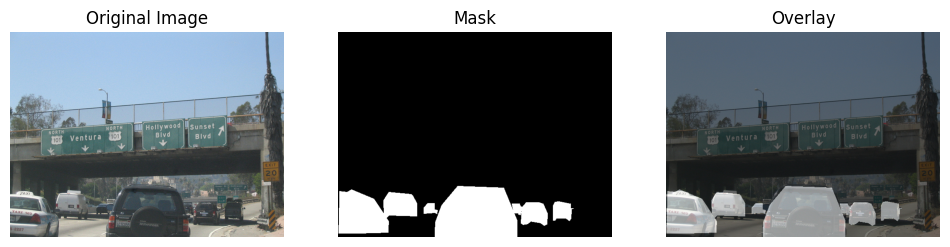

In [ ]:
# Define the paths to the image and mask
image_path = '/content/drive/MyDrive/Assignment_data/validation-300/data/000000001532.jpg'
mask_path = '/content/drive/MyDrive/Assignment_data/validation/masks/000000001532_mask.png'

# Load the image
image = Image.open(image_path)

# Load the mask
mask = Image.open(mask_path)

# Overlay the mask on the image
overlay = Image.blend(image.convert("RGBA"), mask.convert("RGBA"), alpha=0.5)

# Plot the original image, mask, and overlay
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title('Overlay')
plt.axis('off')

plt.show()


In [ ]:
# Paths
train_img_dir = '/content/drive/MyDrive/Assignment_data/train-300/data'
train_mask_dir = '/content/drive/MyDrive/Assignment_data/train/masks'
valid_img_dir = '/content/drive/MyDrive/Assignment_data/validation-300/data'
valid_mask_dir = '/content/drive/MyDrive/Assignment_data/validation/masks'

# Function to load and resize images from directory
def load_images_from_dir(image_dir, target_size=(256, 256)):
    images = []
    for filename in os.listdir(image_dir):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)  # Read image using OpenCV
        if img is not None:
            img = cv2.resize(img, target_size)  # Resize image to target size
            img = img.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img)
    return images

# Function to load and resize masks from directory
def load_masks_from_dir(mask_dir, target_size=(256, 256)):
    masks = []
    for filename in os.listdir(mask_dir):
        mask_path = os.path.join(mask_dir, filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale image
        if mask is not None:
            mask = cv2.resize(mask, target_size)  # Resize mask to target size
            mask = mask.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
            masks.append(mask)
    return masks

# Load training images and masks
train_images = load_images_from_dir(train_img_dir)
train_masks = load_masks_from_dir(train_mask_dir)

# Load validation images and masks
valid_images = load_images_from_dir(valid_img_dir)
valid_masks = load_masks_from_dir(valid_mask_dir)

# Convert lists to numpy arrays
train_images = np.array(train_images)
train_masks = np.array(train_masks)
valid_images = np.array(valid_images)
valid_masks = np.array(valid_masks)

# Print shapes of loaded data
print("Train Images Shape:", train_images.shape)
print("Train Masks Shape:", train_masks.shape)
print("Valid Images Shape:", valid_images.shape)
print("Valid Masks Shape:", valid_masks.shape)


Train Images Shape: (300, 256, 256, 3)
Train Masks Shape: (300, 256, 256)
Valid Images Shape: (300, 256, 256, 3)
Valid Masks Shape: (300, 256, 256)


In [ ]:
# Define the U-Net model architecture
def unet_model(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)


    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)


    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)


    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    up4 = layers.Conv2D(128, 2, activation='relu', padding='same')(up4)
    merge4 = layers.concatenate([conv2, up4], axis=3)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.Conv2D(64, 2, activation='relu', padding='same')(up5)
    merge5 = layers.concatenate([conv1, up5], axis=3)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)


    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)  # Sigmoid activation for binary segmentation

    # Create model
    model = models.Model(inputs, outputs)
    return model



# Initialize early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Initialize and compile the model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping callback
history = model.fit(train_images, train_masks, epochs=5, batch_size=16,
                    validation_data=(valid_images, valid_masks),
                    callbacks=[early_stopping])


Epoch 1/5
19/19 [==============================] - 74s 2s/step - loss: 0.5833 - accuracy: 0.8645 - val_loss: 0.4605 - val_accuracy: 0.8546
Epoch 2/5
19/19 [==============================] - 14s 770ms/step - loss: 0.3951 - accuracy: 0.8676 - val_loss: 0.4649 - val_accuracy: 0.8546
Epoch 3/5
19/19 [==============================] - 16s 875ms/step - loss: 0.4080 - accuracy: 0.8676 - val_loss: 0.4186 - val_accuracy: 0.8546
Epoch 4/5
19/19 [==============================] - 15s 786ms/step - loss: 0.3908 - accuracy: 0.8676 - val_loss: 0.4132 - val_accuracy: 0.8546
Epoch 5/5
19/19 [==============================] - 15s 787ms/step - loss: 0.3862 - accuracy: 0.8676 - val_loss: 0.4130 - val_accuracy: 0.8546


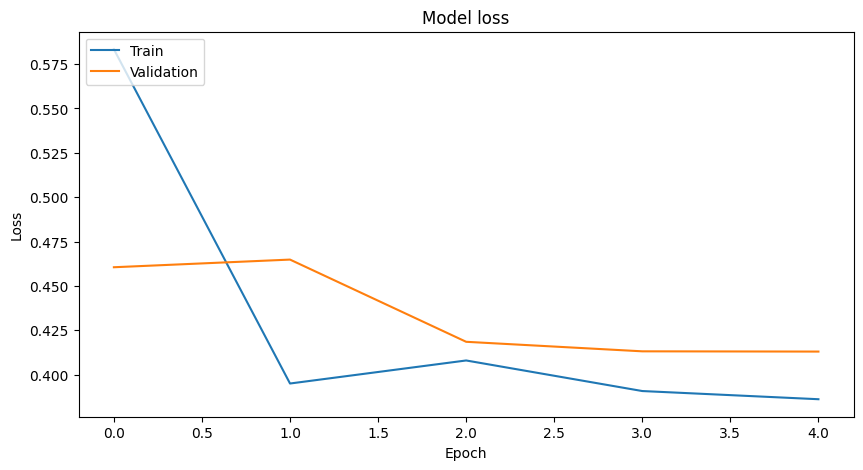

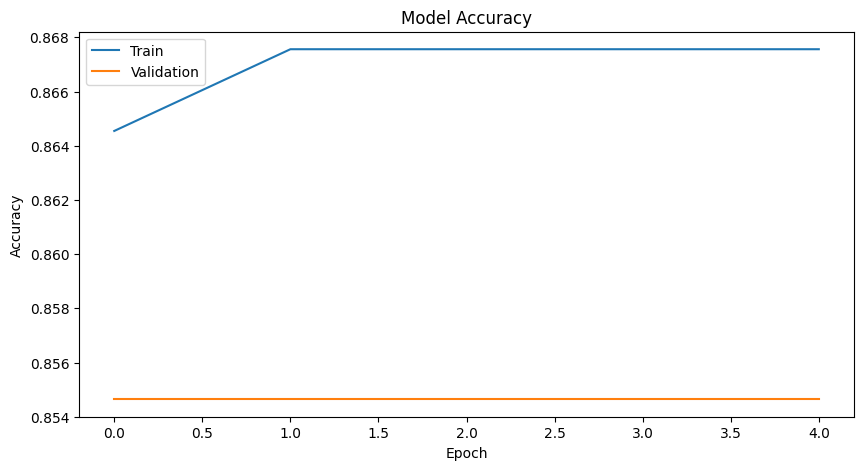

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# test path
test_images = '/content/drive/MyDrive/Assignment_data/test-30'

# Function to load images from directory
def load_images_from_dir(image_dir, target_size=(256, 256)):
    images = []
    for filename in os.listdir(image_dir):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, target_size)
            images.append(img)
    return np.array(images)

test_images = load_images_from_dir(test_images)
predicted_masks = model.predict(test_images)



1/1 [==============================] - 0s 32ms/step


In [ ]:

# Define a function to save predicted masks
def save_predicted_masks(masks, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for i, mask in enumerate(masks):
        mask_path = os.path.join(output_dir, f'mask_{i}.png')
        cv2.imwrite(mask_path, (mask * 255).astype(np.uint8))

# Save the predicted masks
test_mask_dir = '/content/drive/MyDrive/Assignment_data/test/masks'
save_predicted_masks(predicted_masks, test_mask_dir)


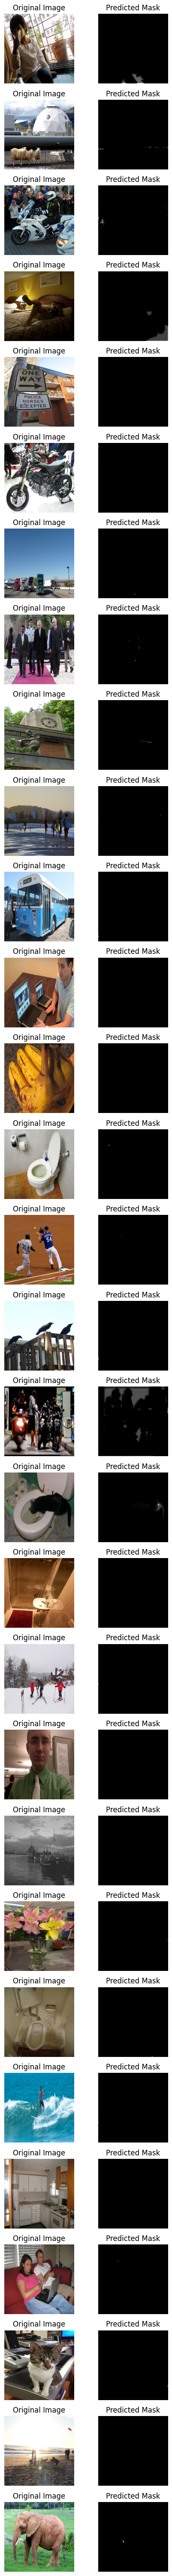

In [ ]:
# Define a function to visualize masks
def visualize_masks(images, masks):
    num_images = len(images)
    fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(5, 2*num_images))

    for i in range(num_images):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title('Predicted Mask')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the predicted masks
visualize_masks(test_images, predicted_masks)